In [70]:
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline
from pmlb import fetch_data
from statistics import mean

In [71]:
df = pd.read_csv(r'C:\Users\sgoethals\Dropbox\PC (2)\Documents\Research\Project Oxford\unfairness_fairml\Unfair_ML\Data\compas-scores-two-years.csv')
dd = df[['sex', 'age', 'age_cat', 'race', 'decile_score', 'priors_count', 'score_text', 'c_charge_degree', 'two_year_recid', 'is_recid', 'days_b_screening_arrest',
        'juv_fel_count', 'juv_misd_count']].replace({
    'Greater than 45':'Above_FourtyFive',
    'Less than 25':'Below_TwentyFive',
    '25 - 45': 'Between_25_45',
    'M':'Misdemeanor',
    'F':'Felony'
})

dd = dd[(dd.days_b_screening_arrest <= 30) & (dd.days_b_screening_arrest >=-30)]\
        .drop(columns=['days_b_screening_arrest','is_recid', 'two_year_recid', 'age_cat'])\
        .assign(score_factor = lambda x: x['score_text'].map(lambda y: 1 if y=='Low' else 0))
dd = dd[(dd.race=='African-American') | (dd.race=='Caucasian')]
dd = dd.assign(
    race = lambda x: (x['race'] == 'Caucasian')*1,
    sex = lambda x: (x.sex == 'Male')*1,
    felony = lambda x: (x.c_charge_degree == 'Felony')*1
         ).drop(columns = ['score_text', 'c_charge_degree'])

X = dd.drop(columns = ['score_factor', 'decile_score'])
#Z = dd.race
y = dd.score_factor
sens_var='race'
sensitive_value=0 
y.value_counts(normalize=True)
good_outcome=1 #low risk factor

In [87]:
%run "C:\Users\sgoethals\Documents\Research\Project Oxford\unfairness_fairml\Unfair_ML\functions\clean_functions.py"

In [91]:
val_results

,protected,target,biased_scores,biased_preds,AUC,AUC_priv,AUC_prot
687,True,0,0.490716,0,0.8206,0.800791,0.808251
4603,True,0,0.109793,0,0.8206,0.800791,0.808251
5495,True,0,0.060218,0,0.8206,0.800791,0.808251
5885,True,1,0.410152,0,0.8206,0.800791,0.808251
2968,False,0,0.305856,0,0.8206,0.800791,0.808251
...,...,...,...,...,...,...,...
1164,True,0,0.135425,0,0.8206,0.800791,0.808251
466,True,0,0.082687,0,0.8206,0.800791,0.808251
6793,True,0,0.480527,0,0.8206,0.800791,0.808251
7046,False,1,0.826899,1,0.8206,0.800791,0.808251


In [88]:
model='xgb'
test_results, val_results=run_constraints_xgb(X,y, sens_var, sensitive_value)
test_metrics=run_all_results_clean(test_results, val_results, good_outcome)

Run biased model
The AUC of the biased model (validation set) is: 0.8206001455791839
The AUC of the biased model (test set) is: 0.8111672523550192
The AUC of the biased model for the protected group (validation set) is: 0.8082514658234258
The AUC of the biased model for the privileged group (validation set) is: 0.8007908438942923
The AUC of the biased model for the protected group (test set) is: 0.7929468184653775
The AUC of the biased model for the privileged group (test set) is: 0.7967688740856844
Calculate demographic parity


100%|██████████| 100/100 [00:05<00:00, 19.42it/s]


Calculate equality of opportunity


100%|██████████| 100/100 [04:22<00:00,  2.63s/it]


Calculate precision


100%|██████████| 100/100 [00:00<00:00, 108.87it/s]


Calculate recall


100%|██████████| 100/100 [00:00<00:00, 138.81it/s]


In [89]:
print('Percentage of people in the protected group {}'.format(test_results.protected.mean()))
print('Percentage of people with the target value {}'.format(test_results.target.mean()))
print('The base rate disparity is {}'.format(test_results[test_results.protected==False].target.value_counts(normalize=True)[good_outcome] - test_results[test_results.protected==True].target.value_counts(normalize=True)[good_outcome]))


Percentage of people in the protected group 0.6015151515151516
Percentage of people with the target value 0.5212121212121212
The base rate disparity is 0.24602771738609913


In [90]:
#base rate disparity
print('The base rate disparity is {}'.format(test_results[test_results.protected==False].target.value_counts(normalize=True)[good_outcome] - test_results[test_results.protected==True].target.value_counts(normalize=True)[good_outcome]))
print('The average cost of fairness (DP) is {}'.format(mean([a - b for a, b in zip(test_metrics['prec_unfair'], test_metrics['prec_dp'])])))
print('The average cost of fairness (EO) is {}'.format(mean([a - b for a, b in zip(test_metrics['prec_unfair'], test_metrics['prec_eo'])])))

The base rate disparity is 0.24602771738609913
The average cost of fairness (DP) is 0.02463820953039658
The average cost of fairness (EO) is 0.013320346719796716


In [93]:
# save results
import pickle

with open(f'Results/Compas_test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)
with open(f'Results/Compas_test_metrics.pkl', 'wb') as f:
    pickle.dump(test_metrics, f)

In [68]:
%run "C:\Users\sgoethals\Documents\Research\Project Oxford\unfairness_fairml\Unfair_ML\functions\visualisations.py"

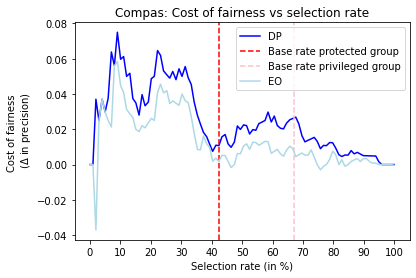

In [92]:
C_list=[i for i in np.linspace(start=1, stop=len(test_results), num=100, dtype=int)]
dataset='Compas'
plot_cost(test_metrics['prec_unfair'],test_metrics['prec_dp'],C_list, test_results, 'precision', 'DP', dataset, test_metrics['prec_eo'], 'EO')   